In [1]:
# Configurações para a apresentação de slides com o Jupyter Notebook
# Instalar temas do Jupyter:
# >> pip install jupyterthemes
# Listar temas disponíveis:
# >> jt -l
# Selecionar o tema para a apresentação:
# >> jt -t monokai
# Retornar ao tema original:
# >> jt -r

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
    "start_slideshow_at": "selected",
    "transition": "zoom",
    "height": 768,
    "width": 1024,
    "theme": "simple",
    "scroll": True,
})

{'theme': 'simple',
 'transition': 'zoom',
 'start_slideshow_at': 'selected',
 'width': 1024,
 'height': 768,
 'scroll': True}

# Bônus - Análise de Dados de Processo!

#### RECOMENDAÇÕES de módulos para Análise de Séries Temporais (ir direto aos exemplos :) )
* [scipy.signal](https://docs.scipy.org/doc/scipy/reference/tutorial/signal.html)
* [statsmodels.tsa.stattools](https://www.statsmodels.org/stable/examples/index.html#stats)

#### Dicas para usar o Jupyter Notebook
* [28 Jupyter Notebook Tips, Tricks, and Shortcuts](https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts)

In [1]:
# No ambiente Jupyter - fazer gráfico no próprio ambiente usando a MATPLOTLIB
%matplotlib inline

# Importação dos princiapais módulos utilizados em análises de dados de processo
# Dica:
# Sempre procurar tratar as exceções para facilitar a manutenção dos códigos e a utilização por terceiros!
try:
    import numpy as np
    import datetime
    import pytz
    import matplotlib.pyplot as plt
    from scipy import signal
    import statsmodels as sm
    from statsmodels.tsa.stattools import adfuller  # https://www.statsmodels.org/stable/examples/index.html#stats
    import pandas as pd
    from gekko import GEKKO
    import getpass
    # Importação do módulo para conecão com o EPM Server (via EPM Web Server)
    import epmwebapi as epm
    print('Módulos importados com sucesso!')
except ImportError as error:
    print('Erro na importação!')
    print(error.__class__.__name__ + ': ' + error.message)
except Exception as exception:
    print(exception.__class__.__name__ + ': ' + exception.message)

Módulos importados com sucesso!


In [2]:
# ATENÇÃO:
# Para uso em produção, é recomendado usar variáveis de ambiente para buscar informações de Usuário/Senha.
# Para este minicurso será utilizado as funções input e getpass
user = input('EPM user:')
password = getpass.getpass("EPM password:")
epm_auth = 'http://epmtr.elipse.com.br/auth' # 'http://localhost:44333'
epm_web  = 'http://epmtr.elipse.com.br'# 'http://localhost:44332'

# Criação de uma conexão informando os endereços do EPM Webserver(Authentication Port e WEB API Port), usuário e senha.
try:
    epmConn = epm.EpmConnection(epm_auth, epm_web, user, password)
    # A forma mais recomendada (fácil) para usar o comando print é com fstring
    print(f'Conexão com {epm_web} criada com sucesso para o usuário {user}.')
except:
    print(f'Falha no estabelecimento da conexão com {epm_web} para o usuário {user}.')

EPM user:truser
EPM password:········
Conexão com http://epmtr.elipse.com.br criada com sucesso para o usuário truser.


# Filtro digital - removendo ruídos de medida

#### Usando a função filtfilt do módulo [scipy.signal](https://docs.scipy.org/doc/scipy/reference/signal.html)
* Esta função implementa um filtro linear digital que é aplicado nos dois sentidos;
* Filtrar nos dois sentidos faz com que o resultado tenha *phase* igual a zero;
* Fazer um *help(signal.filtfilt)* para ver mais detalhes sobre a função - usaremos apenas 3 argumentos:
    * a, b: coeficientes do denominador e numeradores do filtro, respectivamente
    * v   : vetor com os dados a serem filtrados
* "Projetar" um filtro deste tipo, siginifica definir os valores de *a* e *b* segundo alguma característica desejável;
* Tipicamente para dados deste tipo, um filtro passa baixa de Butterworth, costuma trazer bons resultados (ver: [Butterworth Filter Design](https://www.electronics-tutorials.ws/filter/filter_8.html) );
* Existe uma função na *scipy.signal* para isso - fazer *help(signal.butter)* para aprender mais, usaremos apenas 2 argumentos:
    * N: ordem do filtro
    * Wn: frequência crítica

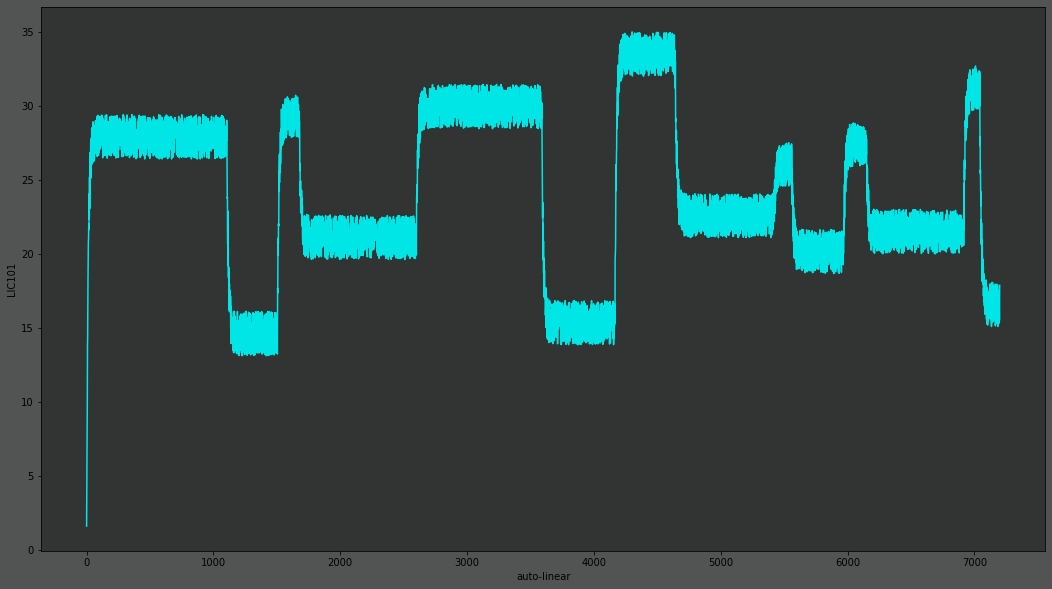

In [3]:
# Buscando um perído com uma variável bem ruidosa :) - já interpoalada a cada segundo
bv_LIC101 = epmConn.getDataObjects(['LIC101'])['LIC101']
# Valores "devem" ser informados em conforemidade com o Timezone ou em UTC (Coordinated Universal Time)
ini_date = datetime.datetime(2014, 3, 4, 2, tzinfo=pytz.utc)
end_date = datetime.datetime(2014, 3, 4, 4, tzinfo=pytz.utc)
query_period = epm.QueryPeriod(ini_date, end_date)
process_interval = datetime.timedelta(seconds=1)
# Dica: usar TAB após "epm.AggregateType." para ver métodos disponíveis (intelisense)
aggregate_details = epm.AggregateDetails(process_interval, epm.AggregateType.Interpolative)
try:
    data = bv_LIC101.historyReadAggregate(aggregate_details, query_period)
    plt.plot(data['Value'], color='#00e6e6') # plot apenas dos dados
    plt.xlabel("auto-linear")
    plt.ylabel(bv_LIC101.name)
    fig = plt.gcf()
    ax = plt.gca()
    fig.set_size_inches(18, 10)
    fig.patch.set_facecolor('#525454')
    ax.set_facecolor('#323434')
except Exception as exception:
    print(exception.__class__.__name__ + ': ' + exception.message)

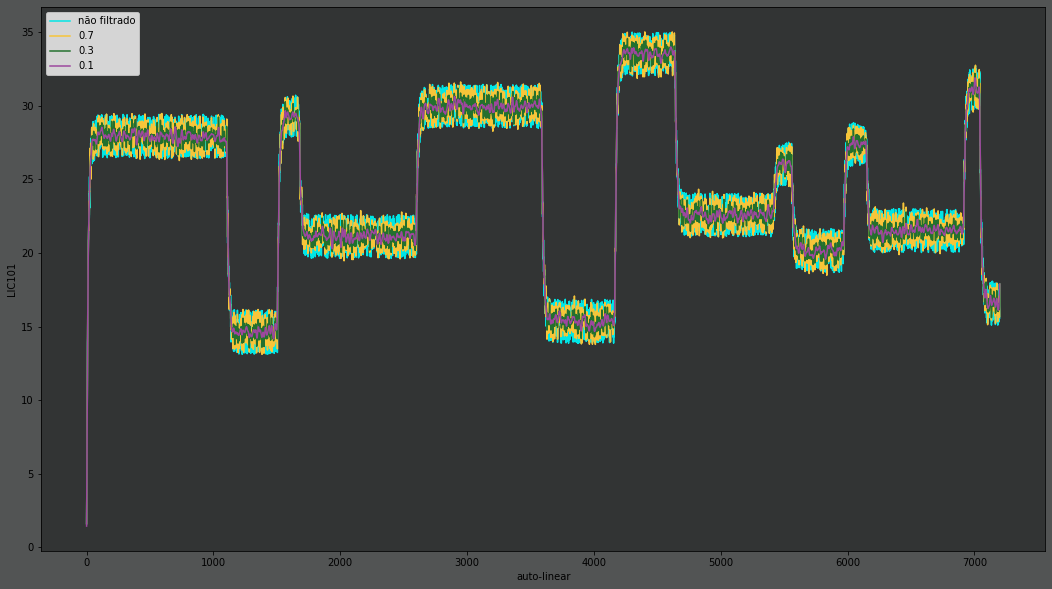

In [4]:
# Aplicando 3 filtros com frequências diferentes para ver o efeito da definição correta da mesma
cut_off_list = [0.7, 0.3, 0.1] # N vezes a frequência de Nyquist
color_list = ['#f7c539', '#23702e', '#9d479e']
order = 2
yf = []
for wn in cut_off_list:
    b, a = signal.butter(order, wn)
    yf.append(signal.filtfilt(b, a, data['Value']))
plt.plot(data['Value'], color='#00e6e6') # plot apenas dos dados
c = 0
for y in yf:
    plt.plot(y, color=color_list[c]) # plot dos valores filtrados
    c += 1
plt.xlabel("auto-linear")
plt.ylabel(bv_LIC101.name)
fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(18, 10)
fig.patch.set_facecolor('#525454')
ax.set_facecolor('#323434')
legend = ['não filtrado'] + list(map(str, cut_off_list)) # Transforma lista de num. em de Strings
ax.legend(legend)

# Derivando o sinal - deixando dados estacionários

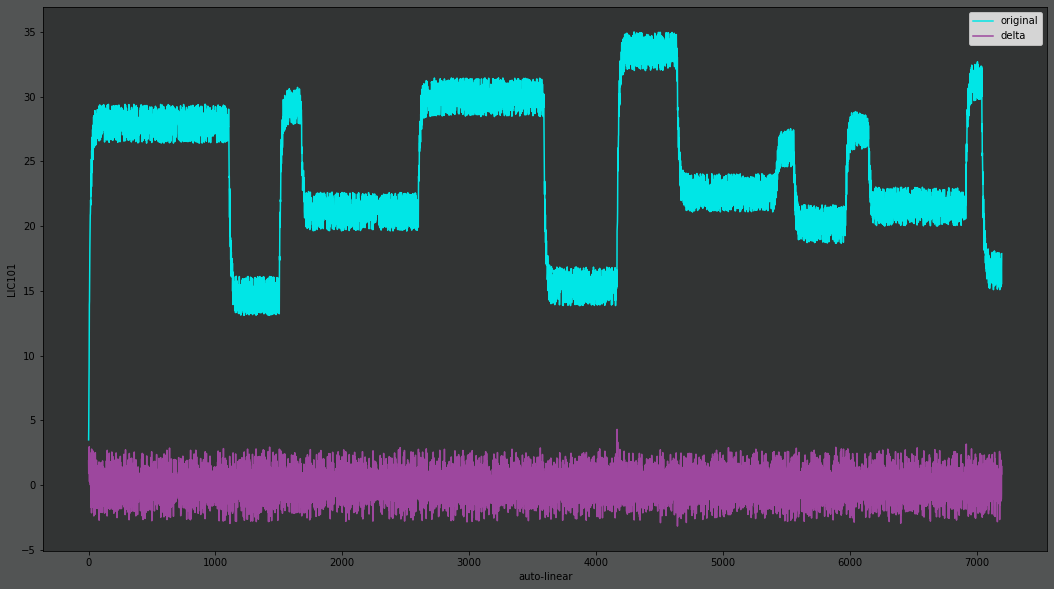

In [10]:
# Uma abordagem simples é aplicar um delta simples (faz um shift unitário dos dados e subtrai)
delta = data['Value'][1:] - data['Value'][:-1]
t = np.arange(len(delta))
plt.plot(t, data['Value'][1:], color='#00e6e6') # plot dos dados originais
plt.plot(t, delta, color='#9d479e') # plot do delta
plt.xlabel("auto-linear")
plt.ylabel(bv_LIC101.name)
fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(18, 10)
fig.patch.set_facecolor('#525454')
ax.set_facecolor('#323434')
ax.legend(['original', 'delta'])

# Quantificando a "estacionaridade" :)

#### Existem diversas formas de definir se um sinal é ou não estacionário (além da visual :) ), mas, de maneira mais simples, pode-se dizer que um sinal é estacionário se a sua média e variância não se alteram ao longo do tempo - além de outras propriedades.
* Uma das formas mais usuais de verificar se um sinal é estacionário ou não, é através de um teste de hipótese chamado de *Augmented Dickey-Fulle* ([statsmodels.tsa.stattools.adfuller](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html));
* Objetivamente:
    * $H_0$: série temporal não é estacionária $\rightarrow$ para 5% $\rightarrow$ $pvalue > 0.05$
    * $H_1$: série temporal é estacionária     $\rightarrow$ para 5% $\rightarrow$ $pvalue \geq 0.05$

In [11]:
# Dados sem aplicação do delta
r1 = adfuller(data['Value'][1:])
print('ADF Statistic: %f' % r1[0])
print('p-value: %f' % r1[1])
print('Critical Values:')
for key, value in r1[4].items():
	print('\t%s: %.3f' % (key, value))
# Dados com a aplicação do delta
r2 = adfuller(delta)
print('ADF Statistic: %f' % r2[0])
print('p-value: %f' % r2[1])
print('Critical Values:')
for key, value in r2[4].items():
	print('\t%s: %.3f' % (key, value))

# ADF_1 -4 é menor que -3 (a 5 %) , isso sugere que podemos rejeitar H0, ou seja, sinal é estacionário!
# ADF_2 -15 é MUITO menor que -3.4 (a 1 %) , isso sugere que podemos rejeitar H0, ou seja, sinal é estacionário!

ADF Statistic: -3.833713
p-value: 0.002581
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
ADF Statistic: -15.388304
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


# Remoção de tendências (não é magia... :) )

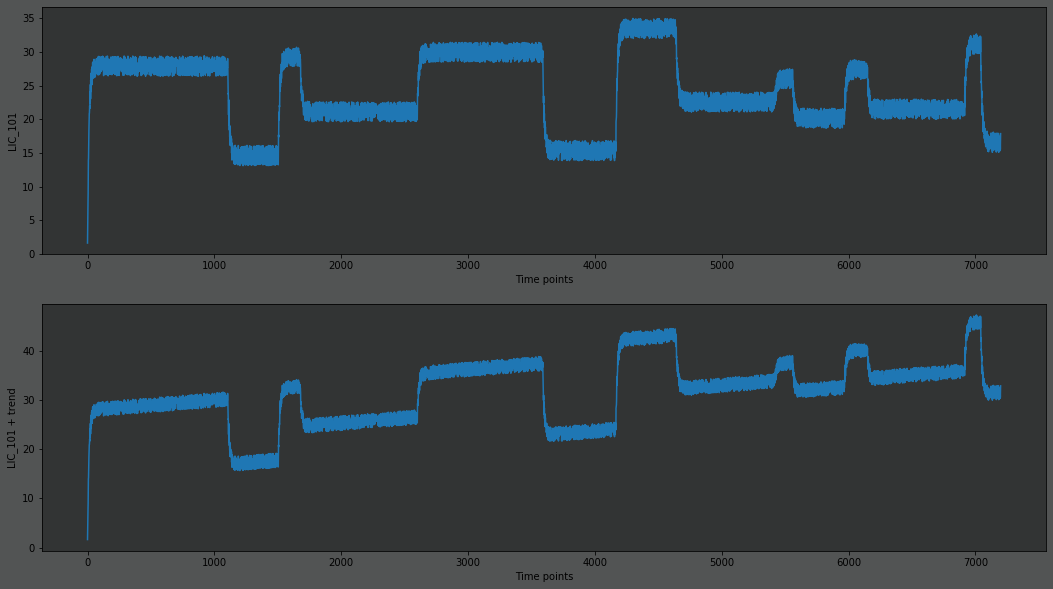

In [30]:
# Suponde a adição de uma constante no nosso sinal original
n = len(data['Value'])
t = np.arange(n)
y = data['Value'] + 3 * np.linspace(0, 5, n) # Adicionando uma tendência linear positiva
fig, ax = plt.subplots(2, 1)
ax[0].plot(t, data['Value'])
ax[0].set_xlabel('Time points')
ax[0].set_ylabel('LIC_101')
ax[1].plot(t, y)
ax[1].set_xlabel('Time points')
ax[1].set_ylabel('LIC_101 + trend')
fig.set_size_inches(18, 10)
fig.patch.set_facecolor('#525454')
ax[0].set_facecolor('#323434')
ax[1].set_facecolor('#323434')

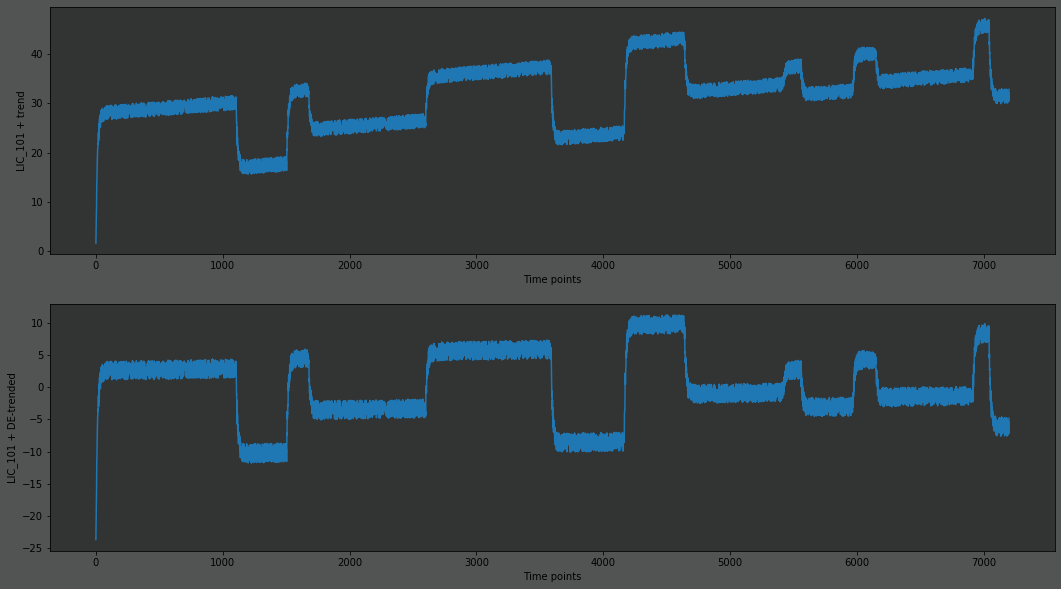

In [32]:
# Removendo a tendência adicionada
y_dtr = signal.detrend(y, type='linear')
fig, ax = plt.subplots(2, 1)
ax[0].plot(t, y)
ax[0].set_xlabel('Time points')
ax[0].set_ylabel('LIC_101 + trend')
ax[1].plot(t, y_dtr)
ax[1].set_xlabel('Time points')
ax[1].set_ylabel('LIC_101 + DE-trended')
fig.set_size_inches(18, 10)
fig.patch.set_facecolor('#525454')
ax[0].set_facecolor('#323434')
ax[1].set_facecolor('#323434')

# Identificação do sistema por uma função de 1ª ordem com tempo morto

#### "Cara" da equação de Primeira ordem mais tempo morto

$\tau \frac{\mathrm{d} y(t)}{\mathrm{d} t} = -y(t) + k u (t - \theta)$

$k$: ganho do processo  $(\frac{\Delta y}{\Delta u})$

$\tau$ : constante de tempo do processo (~ 63% tempo de subida)

$\theta$: tempo morto do processo (é expresso como um deslocamento no tempo do sinal de entrada)

#### Solução da equação

$y(t<\theta) = y(0)$

$y(t>=\theta) = y(0) \exp(-\frac{t-\theta}{\tau}) + k (1 - \exp(-\frac{t-\theta}{\tau}) \Delta u$

#### Solução da equação para cada intervalo de tempo

$y_i = \exp(\frac{-\Delta t}{\tau}) (y_{i-1} - y_0) + k (1 - \exp(-\frac{-\Delta t}{\tau}) (u_{j-\theta - 1} - u_0) + y_0$

#### Solução da equação a um degrau na entrada

$x(t-\theta)=K\;(1-\exp(-(t-\theta)/\tau))$

$y(t)=x(t-\theta)*S(t-\theta)$

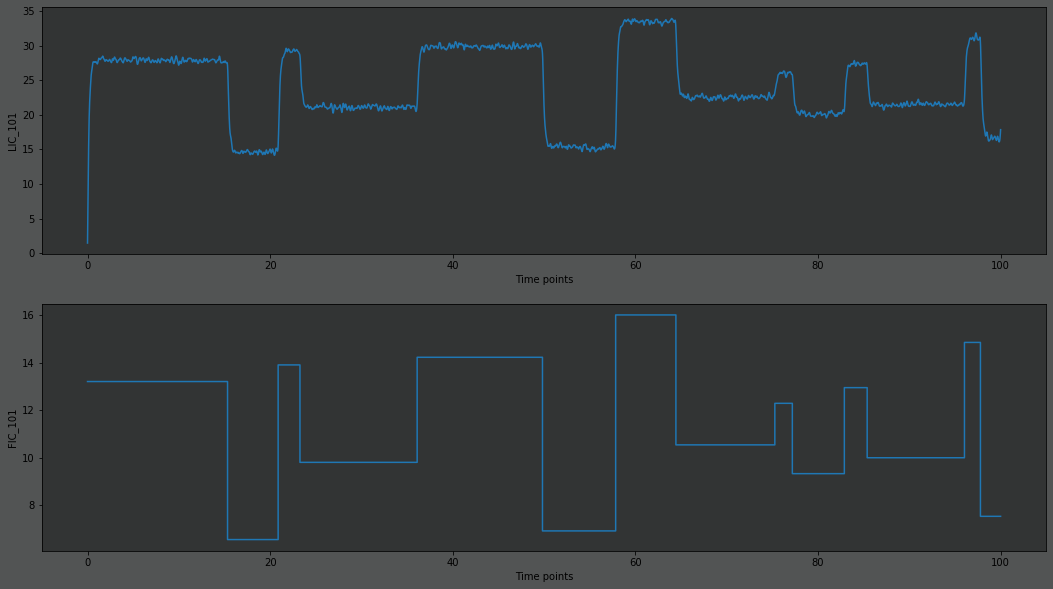

In [5]:
y_meas = yf[2]
n = len(y_meas)
t = np.linspace(0,100,n) # create time vector
# u
bv_FIC101 = epmConn.getDataObjects(['FIC101'])['FIC101']
try:
    u = bv_FIC101.historyReadAggregate(aggregate_details, query_period)
    u_meas = u['Value']
    fig, ax = plt.subplots(2, 1)
    ax[0].plot(t, y_meas)
    ax[0].set_xlabel('Time points')
    ax[0].set_ylabel('LIC_101')
    ax[1].step(t, u_meas)
    ax[1].set_xlabel('Time points')
    ax[1].set_ylabel('FIC_101')
    fig.set_size_inches(18, 10)
    fig.patch.set_facecolor('#525454')
    ax[0].set_facecolor('#323434')
    ax[1].set_facecolor('#323434')
except Exception as exception:
    print(exception.__class__.__name__ + ': ' + exception.message)

In [ ]:
m = GEKKO()
k = m.FV(values=3.0, lb=1.0, ub=50.0)   # Ganho do processo  - FV: Fixed Values por um horizonte de tempo
tau = m.FV(values=1.0, lb=0.1, ub=10.0) # Constante de tempo
theta = m.FV(values=0.0, lb=0.0, ub=5.0)  # Tempo morto
pv = m.Var(value=0)
op = m.Var(value=0)
m.Equation(tau*pv.dt()+pv==)


In [48]:
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d

# Verificar isso: https://youtu.be/RVnId1hU7qE
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d

# Import CSV data file
# Column 1 = time (t)
# Column 2 = input (u)
# Column 3 = output (yp)
data = np.loadtxt('data.txt',delimiter=',')
u0 = data[0,1]
yp0 = data[0,2]
t = data[:,0].T - data[0,0]
u = data[:,1].T
yp = data[:,2].T

# specify number of steps
ns = len(t)
delta_t = t[1]-t[0]
# create linear interpolation of the u data versus time
uf = interp1d(t,u)

# define first-order plus dead-time approximation    
def fopdt(y,t,uf,Km,taum,thetam):
    # arguments
    #  y      = output
    #  t      = time
    #  uf     = input linear function (for time shift)
    #  Km     = model gain
    #  taum   = model time constant
    #  thetam = model time constant
    # time-shift u
    try:
        if (t-thetam) <= 0:
            um = uf(0.0)
        else:
            um = uf(t-thetam)
    except:
        #print('Error with time extrapolation: ' + str(t))
        um = u0
    # calculate derivative
    dydt = (-(y-yp0) + Km * (um-u0))/taum
    return dydt

# simulate FOPDT model with x=[Km,taum,thetam]
def sim_model(x):
    # input arguments
    Km = x[0]
    taum = x[1]
    thetam = x[2]
    # storage for model values
    ym = np.zeros(ns)  # model
    # initial condition
    ym[0] = yp0
    # loop through time steps    
    for i in range(0,ns-1):
        ts = [t[i],t[i+1]]
        y1 = odeint(fopdt,ym[i],ts,args=(uf,Km,taum,thetam))
        ym[i+1] = y1[-1]
    return ym

# define objective
def objective(x):
    # simulate model
    ym = sim_model(x)
    # calculate objective
    obj = 0.0
    for i in range(len(ym)):
        obj = obj + (ym[i]-yp[i])**2    
    # return result
    return obj

# initial guesses
x0 = np.zeros(3)
x0[0] = 2.0 # Km
x0[1] = 3.0 # taum
x0[2] = 0.0 # thetam

# show initial objective
print('Initial SSE Objective: ' + str(objective(x0)))

# optimize Km, taum, thetam
solution = minimize(objective,x0)

# Another way to solve: with bounds on variables
#bnds = ((0.4, 0.6), (1.0, 10.0), (0.0, 30.0))
#solution = minimize(objective,x0,bounds=bnds,method='SLSQP')
x = solution.x

# show final objective
print('Final SSE Objective: ' + str(objective(x)))

print('Kp: ' + str(x[0]))
print('taup: ' + str(x[1]))
print('thetap: ' + str(x[2]))

# calculate model with updated parameters
ym1 = sim_model(x0)
ym2 = sim_model(x)
# plot results
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,yp,'kx-',linewidth=2,label='Process Data')
plt.plot(t,ym1,'b-',linewidth=2,label='Initial Guess')
plt.plot(t,ym2,'r--',linewidth=3,label='Optimized FOPDT')
plt.ylabel('Output')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(t,u,'bx-',linewidth=2)
plt.plot(t,uf(t),'r--',linewidth=3)
plt.legend(['Measured','Interpolated'],loc='best')
plt.ylabel('Input Data')

In [40]:
k = 0.1
tau = 1.0
theta = 0.0
p0 = [k, tau, theta] # chute inicial para os parâmetros
y0 = y_meas[0]
u0 = u_meas[0]
xp0 = [y0,0.0]
# create linear interpolation of the u data versus time
u_interp = interp1d(t, u_meas)

def model1st_pd(x, t, u, k, tau, theta):
    try:
        if (t-theta) <= 0:
            um = u_interp(0.0)
        else:
            um = u_interp(t-theta)
    except:
        um = u0
    # Dois estados (y and y')
    y = x[0] - y0
    dydt = x[1]
    dy2dt2 = k * (1.0 -np.exp(-(t-theta)/tau)) * (um-u0)   #(-2.0*zeta*taus*dydt - y + Kp*(um-u0))/taus**2
    return [dydt,dy2dt2]
    ## Criando um dalay
    #delay = np.empty_like(t)
    #for i in range(n):
    #    if t[i] < theta:
    #        delay[i] = 0.0
    #    else:
    #        delay[i] = 1.0
    ## Cálcula da resposta a um degrau na entrada
    #x = k * (1.0 -np.exp(-(t-theta)/tau))
    #y = x * delay
    #return y

def sim_model1st_pd(p):
    k     = p[0]
    tau   = p[1]
    theta = p[2]
    # storage for model values
    xm = np.zeros((n,2))  # model
    # initial condition
    xm[0] = xp0
    # loop through time steps    
    for i in range(0,n-1):
        ts = [t[i],t[i+1]]
        inputs = (u_interp, k, tau, theta)
        # turn off warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            # integrate SOPDT model
            x = odeint(model1st_pd, xm[i], ts, args=inputs)
        xm[i+1] = x[-1]
    y = xm[:,0]
    return y
    
def objective_function(p):
    # Simula o modelo
    y_est = sim_model1st_pd(p)
    # Cálculo da função objetivo
    sse = 0.0
    for i in range(len(y_est)):
        obj = obj + (y_est[i] - y_meas[i])**2 
    return sse
    ## Penalidades
    #if tau < 0.1:
    #    sse = sse + 100.0 * (0.1-tau)**2
    #if tau > 100:
    #    sse = sse + 100.0 * (100-tau)**2
    #if theta < 0.0:
    #    sse = sse + 100.0 * (theta)**2
    #if theta > 10000:
    #    sse = sse + 100.0 * (10000-theta)**2
    #return sse

    

In [ ]:
# Otimizando para: k, tau, theta
solution = minimize(objective_function, p0)
p_est = solution.x
# show final objective
print('Final SSE Objective: ' + str(objective_function(p_est)))

print('k: ' + str(p_est[0]))
print('tau: ' + str(p_est[1]))
print('theta: ' + str(p_est[2]))

In [ ]:
# calculate model with updated parameters
ym1 = sim_model1st_pd(p0)
ym2 = sim_model1st_pd(p)
# plot results
plt.figure()
plt.subplot(2,1,1)
plt.plot(t, ym1,'b-', linewidth=2, label='Initial Guess')
plt.plot(t, ym2,'r--', linewidth=3, label='Optimized SOPDT')
plt.plot(t, y_meas,'k--', linewidth=2, label='Process Data')
plt.ylabel('Output')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(t, u_meas,'bx-', linewidth=2)
plt.plot(t, u_interp(t),'r--', linewidth=3)
plt.legend(['Measured','Interpolated'], loc='best')
plt.ylabel('Input Data')

fig = plt.gcf()
#ax = plt.gca()
fig.set_size_inches(18, 10)
fig.patch.set_facecolor('#525454')
#ax.set_facecolor('#323434')

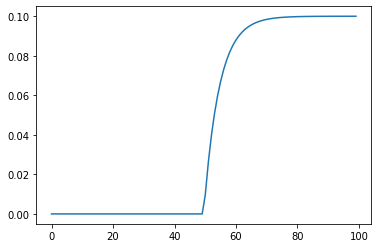

In [42]:
yy = model1st(0, t, 3, k, tau, 10)
plt.plot(yy)

# Análise no domínio da frequência

#### Dica para compreender melhor as análises no domínio da frequência
* [excelente animação - domínio da frequência](https://youtu.be/r18Gi8lSkfM)
* [SciPy 2017: Fast Template Periodogram for Finding Periodic Non Sinusoidal Waveforms in Noisy, Irregularly Samp](https://youtu.be/7STeeVnfYFM)

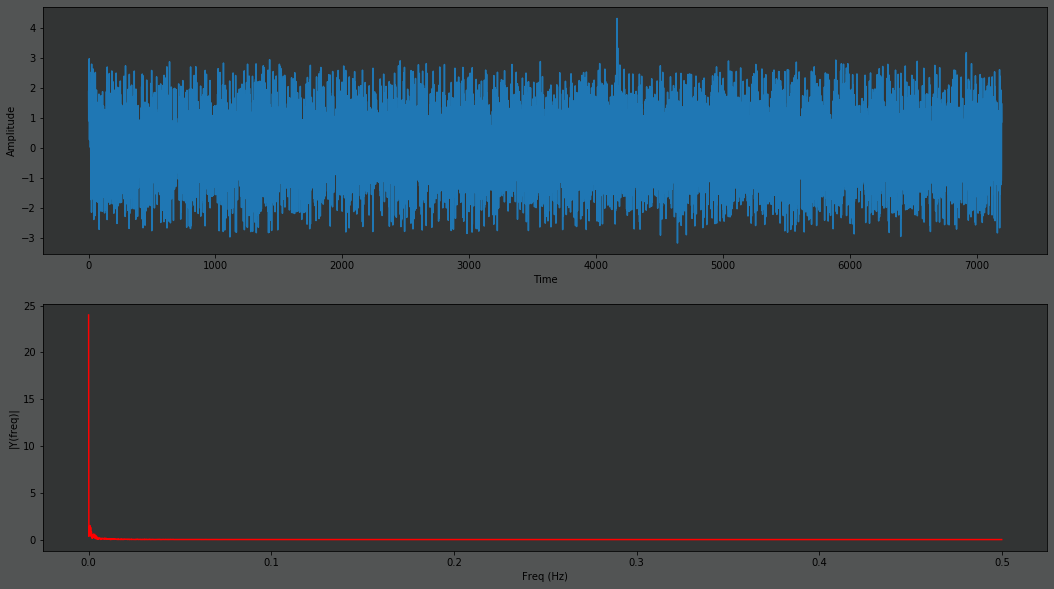

In [17]:
Fs = 1.0;  # taxa de amostragem
Ts = 1.0/Fs; # período de amostragem
n = len(delta)
k = np.arange(n)
T = n/Fs
frq = k/T # frência (nos dois lados)
frq = frq[range(n//2)] # pegando apenas um dos lados
Y = np.fft.fft(y)/n # Transformada rápide de Fourie + normalização
Y = Y[range(n//2)]
fig, ax = plt.subplots(2, 1)
ax[0].plot(t, delta)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
ax[1].plot(frq, abs(Y),'r') # plot do espectro
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('|Y(freq)|')
fig.set_size_inches(18, 10)
fig.patch.set_facecolor('#525454')
ax[0].set_facecolor('#323434')
ax[1].set_facecolor('#323434')

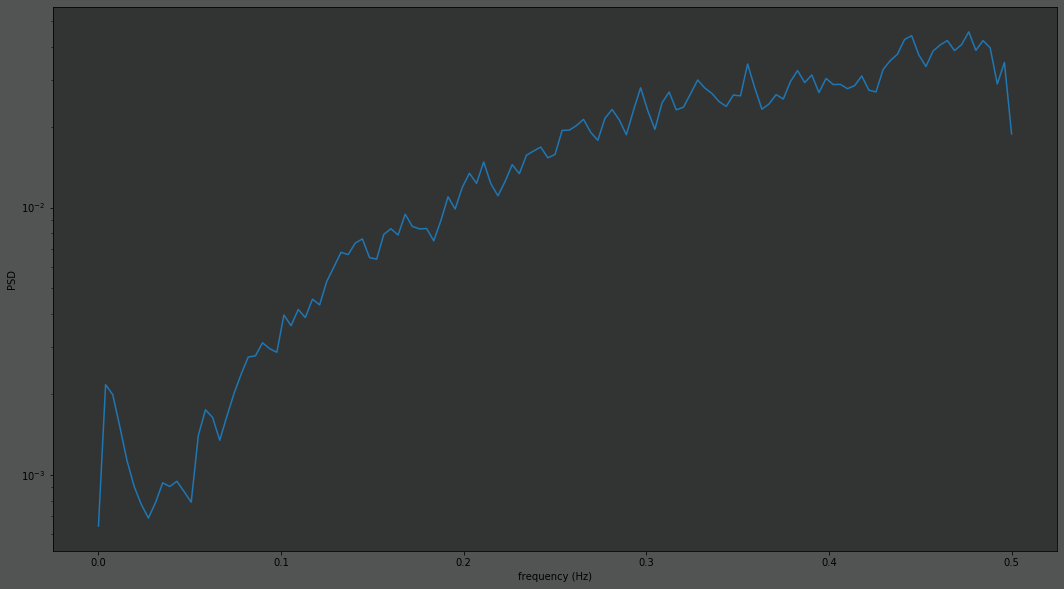

In [37]:
# PERIODIGRAM - PSD (Power Spectral Density)
# Auxilia na captura da frequência do processo estocástico e identifica periodicidades
fs = 1 # Frequência de amostragem -> f_nyquist = fs/2
y = delta # data['Value']
n = len(y)
t = np.arange(n) / fs
#f, Pper_spec = signal.periodogram(data['Value'][1:], fs, 'flattop', scaling='spectrum')
# An improved method, especially with respect to noise immunity, is Welch’s method!
f, Pper_spec = signal.welch(y, fs, scaling='spectrum')
fig, ax = plt.subplots()
ax.semilogy(f, Pper_spec) # plot do espectro
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('PSD')
fig.set_size_inches(18, 10)
fig.patch.set_facecolor('#525454')
ax.set_facecolor('#323434')

# Seleção de um período contínuo de tempo (numpy)

In [43]:
data_sel = data[(data['Timestamp'] > datetime.datetime(2014, 3, 3, 23, 3)) & (data['Timestamp'] < datetime.datetime(2014, 3, 3, 23, 16))]]
t = np.arange(len(data))
plt.plot(t, data['Value'], color='#00e6e6') # plot de todos dos dados
plt.plot(t, data_sel['Value'], color='#9d479e') # plot apenas dos dados selcionados
plt.xlabel("auto-linear")
plt.ylabel(bv_LIC101.name)
fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(18, 10)
fig.patch.set_facecolor('#525454')
ax.set_facecolor('#323434')

SyntaxError: invalid syntax (<ipython-input-43-ae7038969b18>, line 1)

numpy.ndarray

In [47]:
data['Timestamp']

array([datetime.datetime(2014, 3, 4, 2, 0, tzinfo=datetime.timezone.utc),
       datetime.datetime(2014, 3, 4, 2, 0, 1, tzinfo=datetime.timezone.utc),
       datetime.datetime(2014, 3, 4, 2, 0, 2, tzinfo=datetime.timezone.utc),
       ...,
       datetime.datetime(2014, 3, 4, 3, 59, 57, tzinfo=datetime.timezone.utc),
       datetime.datetime(2014, 3, 4, 3, 59, 58, tzinfo=datetime.timezone.utc),
       datetime.datetime(2014, 3, 4, 3, 59, 59, tzinfo=datetime.timezone.utc)],
      dtype=object)

#### É ALTAMENTE RECOMENDADO SEMPRE encerrar a sessão previamente criada !!!

* ao encerrar a sessão, a conexão de *EPM Client* que estava sendo contabilizada na *Hard Key (HK)* é liberada para que outro usuário possa fazer uso dela;
* a sessão tem um *Time out* de 5 minutos - se o processo Python "cair", a sessão será liberada automaticamente após transcorrido este tempo;

In [26]:
# SEMPRE deve-se encerrar a conexão estabelecida com o EPM Server, pois isso irá encerrar a sessão e
# liberar a licença de EPM Client para que outros, eventualmente, possam utilizá-la.
epmConn.close()

#### DICAS

[Exemplos no GitHub da Elipse Software](https://nbviewer.jupyter.org/github/elipsesoftware/epmwebapi/tree/master/exemplos/)

[EPM para analistas de dados: análises preliminares utilizando o módulo pandas da linguagem Python](https://youtu.be/DPrZv80fOuw)

[Webinar - Agilizando análises no EPM com o poder da linguagem Python](https://youtu.be/1u9z6YD_2P0)

[Webinar - Análise de Dados com Python e Dashboard Web](https://youtu.be/IYg5yutkIhw)

[Exemplos MSP no Anaconda Cloud](https://anaconda.org/mauricioposser)

## _FIM do bônus ..._

#### Retornar à apresentação